## Dependencies  
sudo apt install graphviz  
pip install pandas  
pip install anytree  

## Code

In [1]:
# imports

import math
import time

import pandas as pd

from anytree import Node, RenderTree

In [2]:
def get_entropy(data_df, label_col_name='label'):
    """
    Calculates the entropy of given data. Takes the cluster labels from column name label_col_name.
    
    Parameters
    ----------
    data_df : dataframe of the data
    label_col_name : string, default 'label', contains the labels for the dataset
    """
    
    entropy = 0.0
    labels = data_df[label_col_name].unique()
    for label in labels:
        label_df = data_df[data_df[label_col_name] == label]
        label_ratio = float(len(label_df)) / float(len(data_df))
        
        entropy += (-1) * label_ratio * math.log(label_ratio, 2)
    return entropy

In [3]:
def get_entropy_of_splits(initial_data_df, split_dfs, label_col_name='label'):
    """
    Calculates entropy of the data splits.
    
    Parameters
    ----------
    initial_data_df : combined dataframe of the splits
    split_dfs : dataframes obtained after splitting on some data point
    label_col_name : string, default 'label', contains the labels for the dataset
    
    Returns
    -------
    entropy : combined entropy of the splits
    """
    
    entropy = 0.0
    for split in split_dfs:
        entropy += (float(len(split)) / float(len(initial_data_df))) * get_entropy(split, label_col_name)
        
    return entropy

In [4]:
def get_split_info(data_df, data_col_names, label_col_name):
    """
    Calculates the best way to split the data into two parts based on some feature and value
    
    Parameters
    ----------
    data_df : dataframe of the data
    data_col_names : column names of the features
    label_col_name : string, default 'label', contains the labels for the dataset
    
    Returns
    -------
    split_info : None or a dictionary containing col_name and value for the best binary split
    """
    
    max_change_of_entropy = 0.0
    split_info = {}
    initial_entropy = get_entropy(data_df, label_col_name)
#     print ('initial_entropy', initial_entropy)
    
    for col in data_col_names:
        col_values = list(set(data_df[col]))
#         print (col_values)
        col_values.sort()
        col_values = [col_values[0] - 2] + col_values
        col_values = col_values + [col_values[len(col_values) - 1] + 2]

        for idx in range(len(col_values) - 1):
            split_val = float((col_values[idx] + col_values[idx + 1])) / 2.0
            data_split_1 = data_df[data_df[col] < split_val]
            data_split_2 = data_df[data_df[col] >= split_val]

            split_entropy = get_entropy_of_splits(data_df, [data_split_1, data_split_2], label_col_name)
#             print ('split_entropy', split_entropy)
            
            change_of_entropy = initial_entropy - split_entropy
            if change_of_entropy > max_change_of_entropy:
                split_info['col_name'] = col
                split_info['value'] = split_val
                max_change_of_entropy = change_of_entropy
    return split_info

In [15]:
def stopping_criteria_met(data_df, label_col_name):
    """
    Checks if the node should be split more or not
    
    Parameters
    ----------
    data_df : dataframe of the data
    label_col_name : string, default 'label', contains the labels for the dataset
    
    Returns
    -------
    True is node should not be split more, False otherwise
    """
    
#     print ('stopping_criteria_met', set(data_df[label_col_name]))
    return len(list(set(data_df[label_col_name]))) <= 1

def get_node_label(data_df, label_col_name):
    """
    Gets the node label based on the maximum frequency of the label in the data
    
    Parameters
    ----------
    data_df : dataframe of the data
    label_col_name : string, default 'label', contains the labels for the dataset
    
    Returns
    -------
    None or one of the labels from label_col_name
    """
    
    frequencies = data_df[label_col_name].value_counts()
#     print (frequencies)

    if len(frequencies) == 0:
        return None
    else:
        return frequencies.index[0]
    
def get_node_name_for_visualization(node):
    """
    Gets the displayable representation of anytree node
    
    Parameters
    ----------
    node : anytree node
    
    Returns
    -------
    List of strings to display for the graph node
    """
    return [node.split_info, '\n', node.node_data if node.is_leaf else None]

In [16]:
def build_decision_tree(data_df, data_col_names, label_col_name):
    """
    Builds the decision tree
    
    Parameters
    ----------
    data_df : dataframe of the data
    data_col_names : column names of the features
    label_col_name : string, default 'label', contains the labels for the dataset
    
    Returns
    -------
    Root node of the tree
    """
    
#     print ('-->', len(data_df))
#     print (data_df)
    
    if len(data_df) == 0:
        return None
    
    split_info = get_split_info(data_df, data_col_names, label_col_name)
#     print ('split_info', split_info)
    
    cur_node_output_label = get_node_label(data_df, label_col_name)
    cur_node = Node(str(time.time()), split_info=split_info, output_label=cur_node_output_label, node_data=data_df)
    
#     print (stopping_criteria_met(data_df, label_col_name))
    if stopping_criteria_met(data_df, label_col_name):
#         print ("stopping_criteria_met")
        return cur_node
    
    left_data_df = data_df[data_df[split_info['col_name']] < split_info['value']]
    right_data_df = data_df[data_df[split_info['col_name']] >= split_info['value']]
#     print ('left_data_df, right_data_df', len(left_data_df), len(right_data_df))
    
    if len(left_data_df) > 0 and len(left_data_df) < len(data_df):
        left_child = build_decision_tree(left_data_df, data_col_names, label_col_name)
        if left_child != None:
            left_child.parent = cur_node

    if len(right_data_df) > 0 and len(right_data_df)< len(data_df):
        right_child = build_decision_tree(right_data_df, data_col_names, label_col_name)
        if right_child != None:
            right_child.parent = cur_node
    
    return cur_node

## Test tree

In [17]:
data = [[1, 2, 3, 4], [2, 5, 3, 6], [7, 8, 9, 2], [4, 2, 6, 8], [1, 3, 5, 6]]
data_df = pd.DataFrame(data, columns=['col1', 'col2', 'col3', 'col4'])
data_df['label'] = [1, 2, 2, 1, 2]
print (data_df.head())

cols = data_df.columns
label_col_name = 'label'
data_cols = [x for x in cols if x != label_col_name]
print (data_cols)

   col1  col2  col3  col4  label
0     1     2     3     4      1
1     2     5     3     6      2
2     7     8     9     2      2
3     4     2     6     8      1
4     1     3     5     6      2
['col1', 'col2', 'col3', 'col4']


In [18]:
root_node = build_decision_tree(data_df, data_cols, label_col_name)
root_node

Node('/1538956541.93', node_data=   col1  col2  col3  col4  label
0     1     2     3     4      1
1     2     5     3     6      2
2     7     8     9     2      2
3     4     2     6     8      1
4     1     3     5     6      2, output_label=2, split_info={'col_name': 'col2', 'value': 2.5})

In [19]:
for pre, fill, node in RenderTree(root_node):
    print("%s%s" % (pre, node.name))

1538956541.93
├── 1538956541.94
└── 1538956541.96


## Iris data

In [20]:
iris_data_df = pd.read_csv('iris.data', sep=',', index_col=False, header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
iris_data_df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [21]:
iris_data_df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [22]:
cols = iris_data_df.columns
label_col_name = 'class'
data_cols = [x for x in cols if x != label_col_name]

print (data_cols, label_col_name)
root_node = build_decision_tree(iris_data_df, data_cols, label_col_name)
# print (root_node)

(['sepal length', 'sepal width', 'petal length', 'petal width'], 'class')


In [23]:
for pre, fill, node in RenderTree(root_node):
    print("%s%s %s" % (pre, node.name, node.split_info))

1538956543.17 {'col_name': 'petal length', 'value': 2.45}
├── 1538956543.26 {}
└── 1538956543.47 {'col_name': 'petal width', 'value': 1.75}
    ├── 1538956543.61 {'col_name': 'petal length', 'value': 4.95}
    │   ├── 1538956543.73 {'col_name': 'petal width', 'value': 1.65}
    │   │   ├── 1538956543.83 {}
    │   │   └── 1538956543.85 {}
    │   └── 1538956543.89 {'col_name': 'petal width', 'value': 1.55}
    │       ├── 1538956543.91 {}
    │       └── 1538956543.94 {'col_name': 'sepal length', 'value': 6.95}
    │           ├── 1538956543.96 {}
    │           └── 1538956543.97 {}
    └── 1538956544.09 {'col_name': 'petal length', 'value': 4.85}
        ├── 1538956544.12 {'col_name': 'sepal length', 'value': 5.95}
        │   ├── 1538956544.13 {}
        │   └── 1538956544.14 {}
        └── 1538956544.24 {}


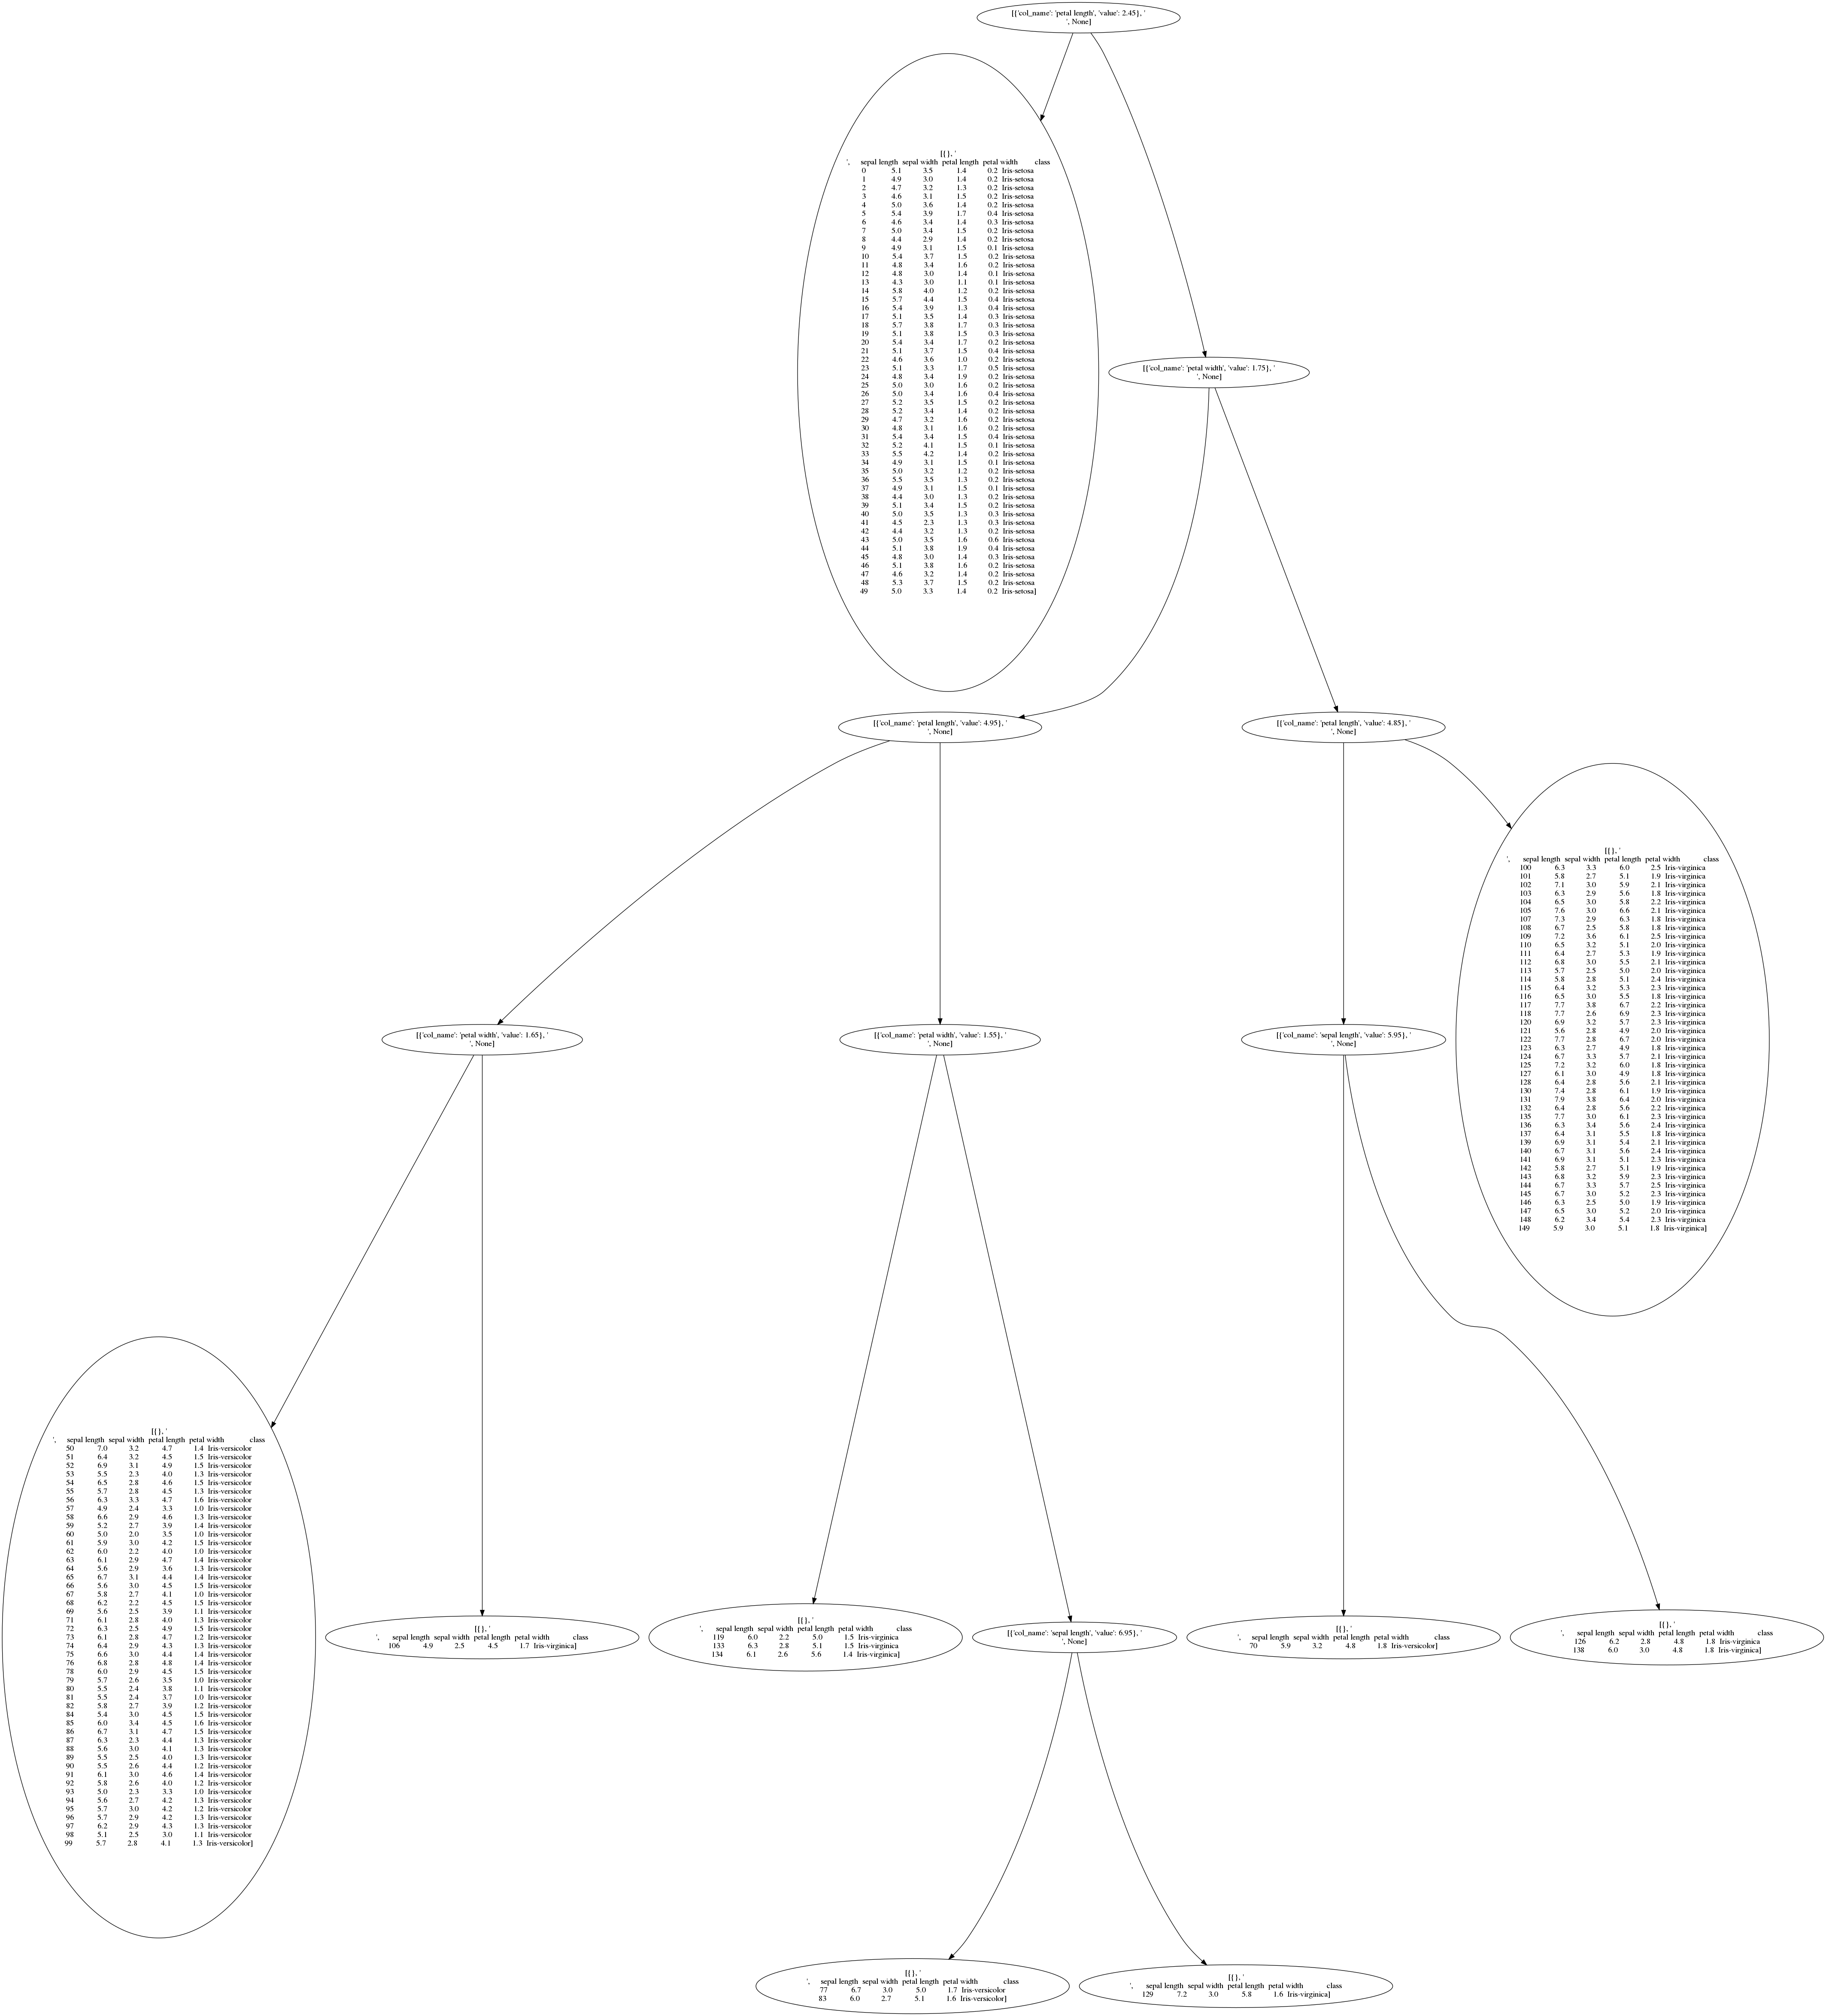

In [25]:
from anytree.exporter import DotExporter
#  graphviz needs to be installed for the next line!
DotExporter(root_node, nodenamefunc=get_node_name_for_visualization).to_picture("dt.png")
from IPython.display import Image
Image("dt.png")